### Инструкция по выполнению проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.



# План работы
1. [Загрузка данные и подготовка их к анализу](#start)
2. [Задание функции для расчета и анализа LTV, ROI, удержания и конверсии
](#functions)
3. [Исследовательский анализ данных](#analysys)
    * [Построение профилей пользователей](#analysys1)
    * [Определение минимальной и максимальной дат привлечения пользователей](#analysys2)
    * [Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?](#analysys3)
    * [Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?](#analysys4)
    * [По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?](#analysys5)
4. [Маркетинг](#marketing)
    * [Сколько денег потратили? Всего / на каждый источник / по времени](#marketing1)
    * [Сколько в среднем стоило привлечение одного покупателя из каждого источника?](#marketing2)
5. [Оценка окупаемости рекламы для привлечения пользователей](#advert)
    * [Анализ общей окупаемости рекламы. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.](#advert1)
    * [Анализ окупаемости рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.](#advert2)
    * [Анализ окупаемости рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.](#advert3)
    * [Построение и изучение графиков конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.](#advert4)
6. [Общий вывод](#conclusions)

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

<a id="start"> <h1> Шаг 1. Загрузка данные и подготовка их к анализу </h1> </a> <br>
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),  # журнал сессий
    pd.read_csv('orders_info_short.csv'),  # покупки
    pd.read_csv('costs_info_short.csv'),  # траты на рекламу
)
visits.head()


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Переименуем названия столбцов, приведя их к стандартному python - виду (строчные буквы и _ вместо пробелов)

In [3]:
def to_low(df):
    for column in df.columns:
        df = df.rename(columns={column:column.lower().replace(' ', '_')})
    return df

In [4]:
visits = to_low(visits)
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
costs = to_low(costs)
orders = to_low(orders)

In [6]:
print(visits.info() , visits.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None             user_id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11


Нужно поменять типы у session_start и session_end. Пропусков в таблице нет

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
orders.info()
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
print(costs.info(), costs.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None              costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000


In [10]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


# Вывод по шагу 1:

Данные проверены. Пропусков нет, данные корректны, дубликатов нет. В столбцах с датой и временем поменян тип на datetime, в остальных замена типа не требовалась. Таблицы готовы для анализа.

<a id="functions"> <h1> Шаг 2. Задание функции для расчета и анализа LTV, ROI, удержания и конверсии </h1></a>

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

In [11]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    
    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            
    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    
    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    
    return profiles

In [12]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [15]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [16]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [17]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

<a id="analysys"> <h1> # Шаг 3. Исследовательский анализ данных </h1> </a>



<a id="analysys1">  Построение профилей пользователей  </a>

In [19]:
profiles = get_profiles(visits, orders,costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [20]:
profiles.head(5) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


<a id="analysys2">   Определение минимальной и максимальной дат привлечения пользователей. </a>

In [21]:
profiles['dt'].min(), profiles['dt'].max() 

(datetime.date(2019, 5, 1), datetime.date(2019, 10, 27))

Определили минимальную и максимальную дату привлечения пользователей - 01.05 и 27.10

<a id="analysys3">  Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей? <a>

In [22]:
region_share = pd.DataFrame()
region_share['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_share['share'] = ((region_share['users_cnt'] / profiles['region'].count()) * 100)
region_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


Две трети всех пользователей из США. Практически одинаковое число пользователей (около 11%) из Великобритании и Франции. Меньше всего (около 10%) из Германии

Рассчитаем теперь долю покупателей - общую и по странам. 

In [23]:
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = ((region_payer_share['users_cnt'] / profiles.query('payer == True')['region'].count()) * 100)
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,6902,77.72%
UK,700,7.88%
France,663,7.47%
Germany,616,6.94%


Платящие пользователи из США лидируют с большим отрывом (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%)

In [24]:
def pivot_share_result(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})

In [25]:
pivot_share_result('region', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


Доля платящих пользователей из США - 6.90%. В Великобритании доля платящих 3.98% (700 человек), во Франции примерно только же. В Германии 4.1%.

<a id="analysys4"> Какими устройствами пользуются пользователи? С каких устройств чаще всего заходят платящие пользователи? </a>

In [26]:
device_share = pd.DataFrame()
device_share['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_share['share'] = ((device_share['users_cnt'] / profiles['device'].count()) * 100)
device_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


Пользователи предпочитают мобильные устройства (36% - айфоны и 23% - андроид) компьютерам: по 20% PC и Mac

In [27]:
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = ((device_payer_share['users_cnt'] / profiles.query('payer == True')['device'].count()) * 100)
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,3382,38.08%
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%


Доля платящих пользователей по-прежнему выше всего для обладателей айфонов (38%), ниже для Андроид (23%) и Мак (22%), меньше всего платящих пользователей с ПК (17%)

In [28]:
pivot_share_result('device', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
device,,,,
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%
Mac,30042,20.03%,1912,6.36%


И сводная таблица по устройствам с долями платящих пользователй

<a id="analysys5">  Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. </a>

In [29]:
channel_share = pd.DataFrame()
channel_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_share['share'] = ((channel_share['users_cnt'] / profiles['channel'].count()) * 100)

channel_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_share['payer_share'] = ((channel_share['payer_users_cnt'] / profiles.query('payer == True')['channel'].count()) * 100)

channel_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,users_cnt,share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.62%,1160,13.06%
FaceBoom,29144,19.43%,3557,40.05%
TipTop,19561,13.04%,1878,21.15%
OppleCreativeMedia,8605,5.74%,233,2.62%
LeapBob,8553,5.70%,262,2.95%
WahooNetBanner,8553,5.70%,453,5.10%
RocketSuperAds,4448,2.97%,352,3.96%
MediaTornado,4364,2.91%,156,1.76%
YRabbit,4312,2.87%,165,1.86%


Больше всего пользователей пришло из органических каналов, но больше всего платящих пользователей - из FaceBoom

In [30]:
pivot_share_result('channel', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.62%,1160,2.06%
FaceBoom,29144,19.43%,3557,12.20%
TipTop,19561,13.04%,1878,9.60%
OppleCreativeMedia,8605,5.74%,233,2.71%
LeapBob,8553,5.70%,262,3.06%
WahooNetBanner,8553,5.70%,453,5.30%
RocketSuperAds,4448,2.97%,352,7.91%
MediaTornado,4364,2.91%,156,3.57%
YRabbit,4312,2.87%,165,3.83%


In [31]:
channel_share.rename(columns={'users_cnt': 'Пользователи', 'share': '% пользователей от общего количества', 'payer_users_cnt': 'Платящие пользователи', 'payer_share': '% платящих'}, inplace=True)
channel_share.sort_values(by='% пользователей от общего количества', ascending=False).style.format({'% пользователей от общего количества': '{:.2f}%', '% платящих': '{:.2f}%'})

,Пользователи,% пользователей от общего количества,Платящие пользователи,% платящих
channel,,,,
organic,56439,37.62%,1160,13.06%
FaceBoom,29144,19.43%,3557,40.05%
TipTop,19561,13.04%,1878,21.15%
OppleCreativeMedia,8605,5.74%,233,2.62%
LeapBob,8553,5.70%,262,2.95%
WahooNetBanner,8553,5.70%,453,5.10%
RocketSuperAds,4448,2.97%,352,3.96%
MediaTornado,4364,2.91%,156,1.76%
YRabbit,4312,2.87%,165,1.86%


# Вывод по шагу 3

1. На данном этапе были сформированы профили пользователей. Определены минимальная и максимальная даты привлечения пользователей. Это 1 мая 2019 и 27 октября 2019.
2. Построена таблица, отражающую количество пользователей и их долю из каждой страны. Большая доля пользователей из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%). 
3. Построена таблица, отражающую количество платящих пользователей и их долю из каждой страны. Платящие пользователи из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%) Доля платящих пользователей из США - 6.90%, в Англии 3.98%, во Франции 3.8%, в Германии 4.1%.
4. По результатам анализа устройств, которыми пользуются клиенты приложения, большинство пользователей - это владельцы IPhone (36%) и Android (23%).  Доли PC и Mac практически одинаковы (по 20%).
5. Больше всего доля платящих пользователей для устройства Mac: 6.36% (1912 человек) из 30042 платят за продукт. Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%. Среди пользователей PC (30455) платящих меньше всего - 5.05% (1537 человек).
6. Проанализированы источники привлечения и определены каналы, из которых пришло больше всего платящих пользователей. Больше всего приходится на органический трафик (38%), далее по числу пользователей идут источники FaceBoom (19%) и TipTop(13%).
7. Большинство платящих пользователей приходится на каналы FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%). Менее всего конвертируются пользователи из каналов organic (2.06%), OppleCreativeMedia (2.71%) и LeapBob (3.06%).

<a id="marketing"> <h1> # Шаг 4. Маркетинг


<a id="marketing1"> Сколько денег потратили? Всего / на каждый источник / по времени </a>

In [32]:
costs.sum()

costs    105497.3
dtype: float64

Всего на маркетинг потрачено 105497.3 

In [33]:
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report['share'] = ((channel_costs_report['costs'] / costs['costs'].sum()) * 100)
channel_costs_report.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,costs,share
channel,,
TipTop,54751.3,51.90%
FaceBoom,32445.6,30.75%
WahooNetBanner,5151,4.88%
AdNonSense,3911.25,3.71%
OppleCreativeMedia,2151.25,2.04%
RocketSuperAds,1833,1.74%
LeapBob,1797.6,1.70%
lambdaMediaAds,1557.6,1.48%
MediaTornado,954.48,0.90%


Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут низкозатратные источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%). На оставшиеся источники приходится 1-2% трат.

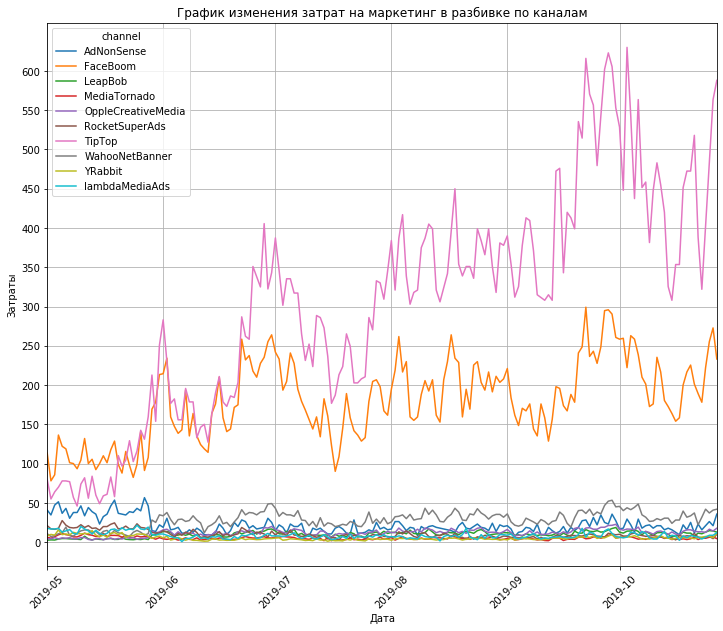

In [34]:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10),
           grid=True, 
           rot=45,        
           label='Каналы',                    
           legend=True,
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('График изменения затрат на маркетинг в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Видим тут двух "активных игроков" - это TipTop и FaceBoom. Больше всего трафика закупали у TipTop и к октябрю число трат приближалось к 650 у.е. Число трат на FaceBoom находится в районе 300. И если остальные источники не показывают какую-либо значительную динамику, то затраты на источник Tip-Top возрастают со временем. Остальные каналы привлечения обходятся довольно дешево. Возможно, стоит посмотреть на них в отдельном срезе, чтобы понять динамику, тк на этом графике данные по ним недостаточно показательны.

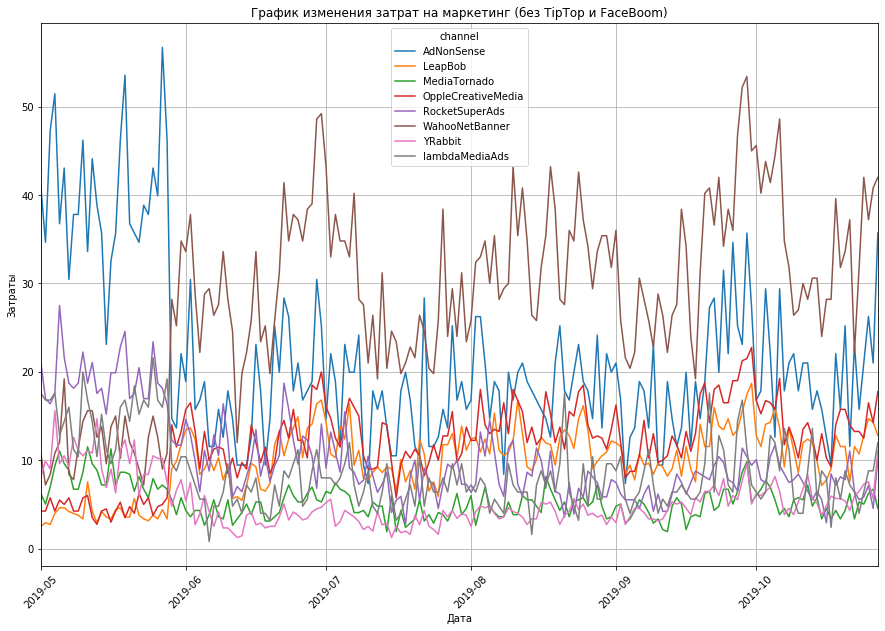

In [35]:
filtered_data2 = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )

filtered_data2.plot(                                             
           figsize=(15, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 

plt.yticks(np.arange(0,  60, 10)) #зададим шаг по oy
plt.title('График изменения затрат на маркетинг (без TipTop и FaceBoom)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Среди рекламных источников помимо TipTop и FaceBoom с июня начали расти траты на WahooNetBanner (к октябрю их число было в районе 53 у.е.). Затраты на AdNonSense, наоборот, стали снижаться с июня 2019 года (с 55 до 35). По остальным источникам траты варьируются в пределах 3-20 у.е.

<a id="marketing2"> Сколько в среднем стоило привлечение одного покупателя из каждого источника? </a>

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.

In [36]:
profiles.describe()

,user_id,acquisition_cost
count,1.500080e+05,150008.000000
mean,4.993238e+11,0.703278
std,2.889483e+11,0.954097
min,5.993260e+05,0.000000
25%,2.489249e+11,0.000000
50%,4.977046e+11,0.247500
75%,7.494919e+11,1.108943
max,9.999996e+11,3.715385


Медианная стоимость привлечения одного пользователя - 0.24. При этом среднее находится на значении 0.7. Вероятно, в какие-то периоды мы тратили на пользователей больше, и в данных есть какие-то выбросы, которые влияют на разницу в стреднем и медианой. Максимальная стоимость привлечения пользователя - 3.71 у.е.

In [37]:
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


In [38]:
profiles = profiles.query('channel != "organic"')
profiles.describe()

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


In [39]:

cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


# Вывод по шагу 4

1. Выяснено, как траты распределены по источникам. Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут низкозатратные источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%). На оставшиеся источники приходится 1-2% трат.
2. Рассмотрено изменение метрик во времени. Больше всего трафика закупали у TipTop, и к октябрю число трат приближалось к 650 у.е. Число трат на FaceBoom находится в районе 300. Остальные каналы привлечения обходятся довольно дешево.
3. Среди рекламных источников помимо TipTop и FaceBoom с июня начали расти траты на WahooNetBanner (к октябрю их число было в районе 53 у.е.). Затраты на AdNonSense, наоборот, стали снижаться с июня 2019 года (с 55 до 35). По остальным источникам траты варьируются в пределах 3-20 у.е.
4. Рассчитан средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Самый дорогой трафик - TipTop (средняя стоимость - 2.80 за пользователя), далее идет FaceBoom и AdNonSense примерно в равной ценовой категории (1.11 и 1.01 соответственно). Органический трафик бесплатен, остальные каналы берут за пользователя от 0.21 до 0.72 у.е.

<a id="advert"> <h1>  Шаг 5. Оцените окупаемость рекламы для привлечения пользователей </h1> </a>

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [40]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Из расчетов нам следует исключить пользователей с органическим трафиком, поскольку мы за них ничего не платим.

In [41]:
profiles = profiles.query('channel != "organic"')

<a id="advert1"> Анализ общей окупаемости рекламы. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI. </a>

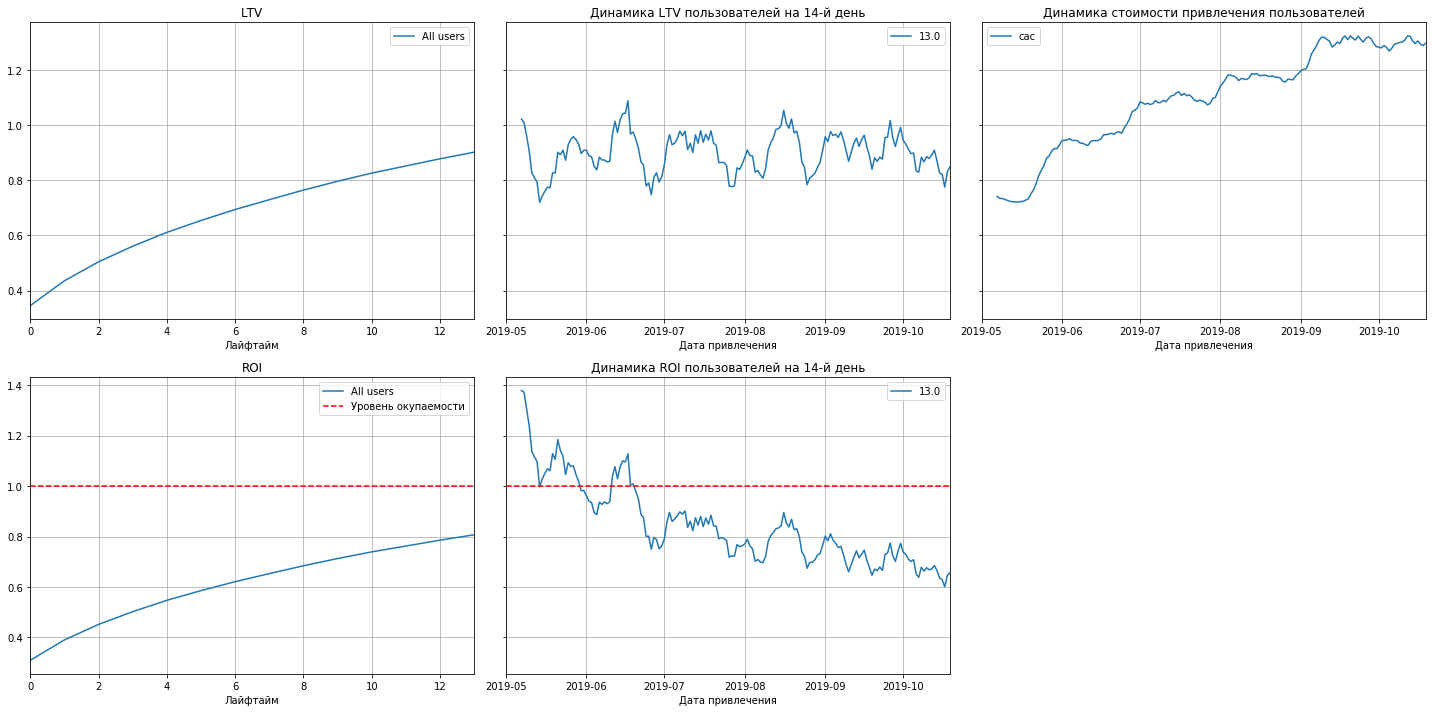

In [42]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

1. Реклама не окупается к концу 2й недели. ROI — около 80%.
2. CAC нестабилен. Рекламный бюджет увеличивается с течением времени.
3. На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
4. ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать.

<a id="advert3"> Анализ окупаемости рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.</a>

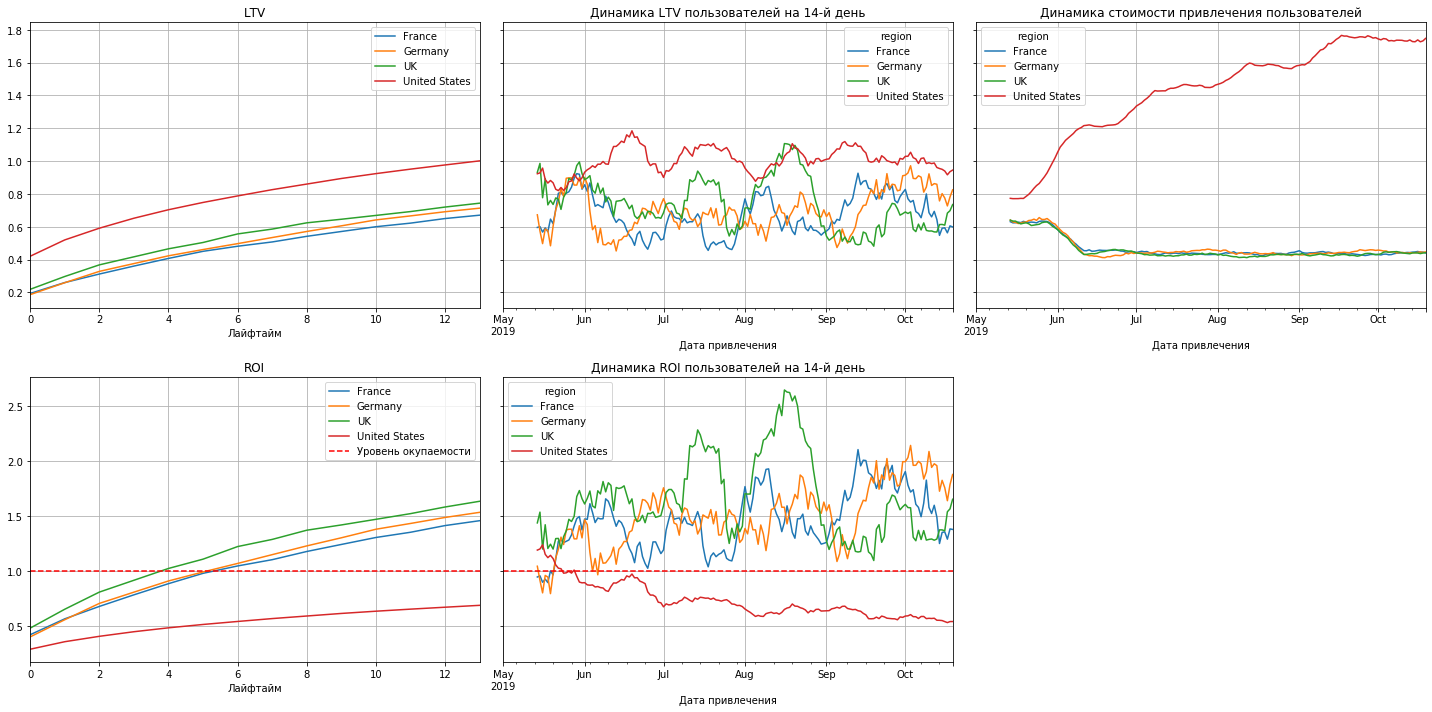

In [43]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Реклама окупается не везде. В США уровень окупаемости рекламы низкий, а, как мы помним, у нас основная аудитория - это пользователи из США.
2. При этом стоимость привлечения пользователей из Америки - самая высокая. И она растет.
3. LTV всё так же подвержен сезонности, но стабилен.
4. Лучше всего окупается Англия и Германия. Явный аутсайдер - США. Причем окупаемость пользователей начала падать с конца июня 2019 года. Возможно, неудачный релиз, запуск похожего продукта у конкурентов или какие-то  изменения в продукте сыграли такую роль, и сервис стал менеее привлекательным для пользователей.<br>
<b>Надо уделить особое внимание США!</b>

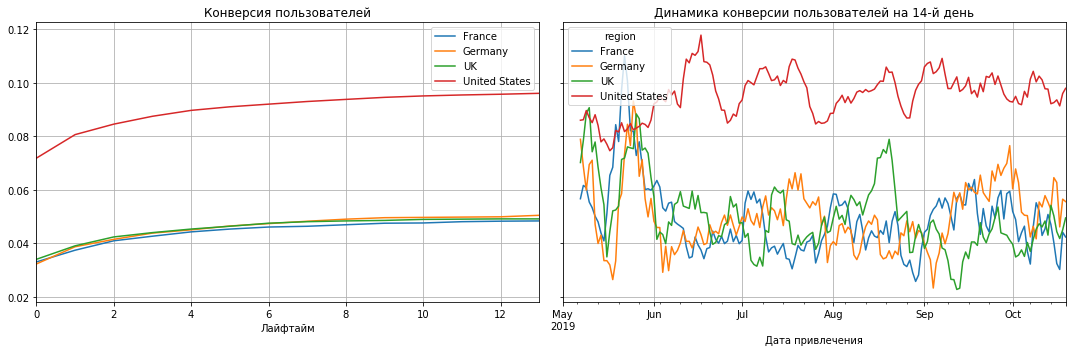

In [44]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

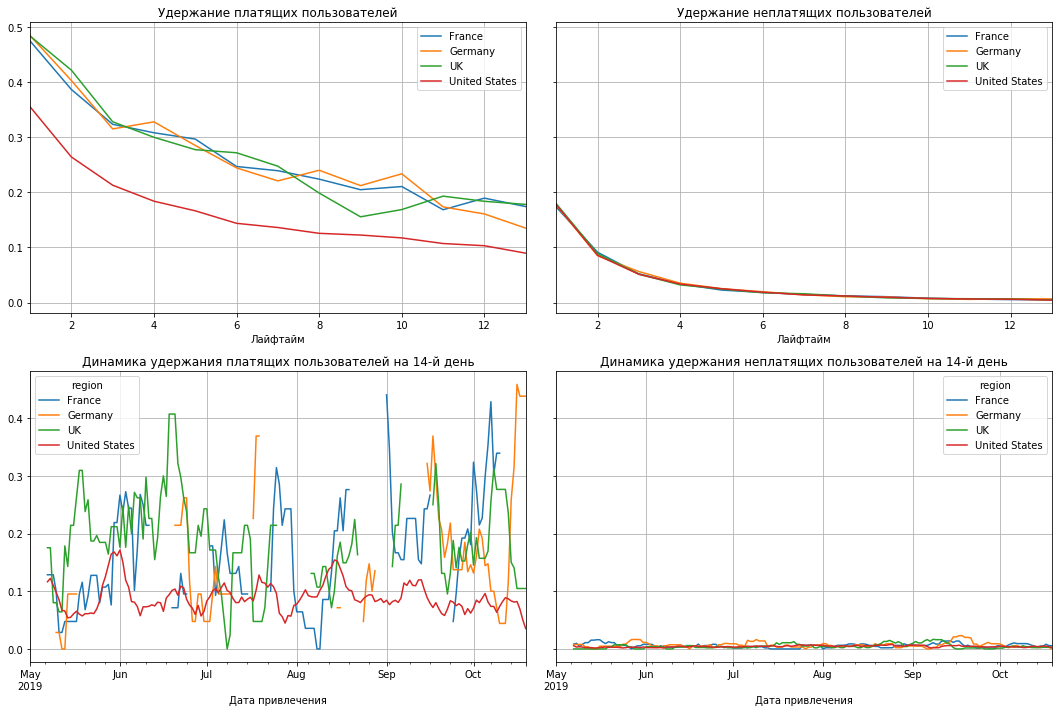

In [45]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи из США явно плохо удерживаются. По конверсии - слабая конверсия у пользователей из Англии, Германии и Франции, но и их доля относительно всех пользователей небольшая.

<a id="advert2"> Анализ окупаемости рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.</a>

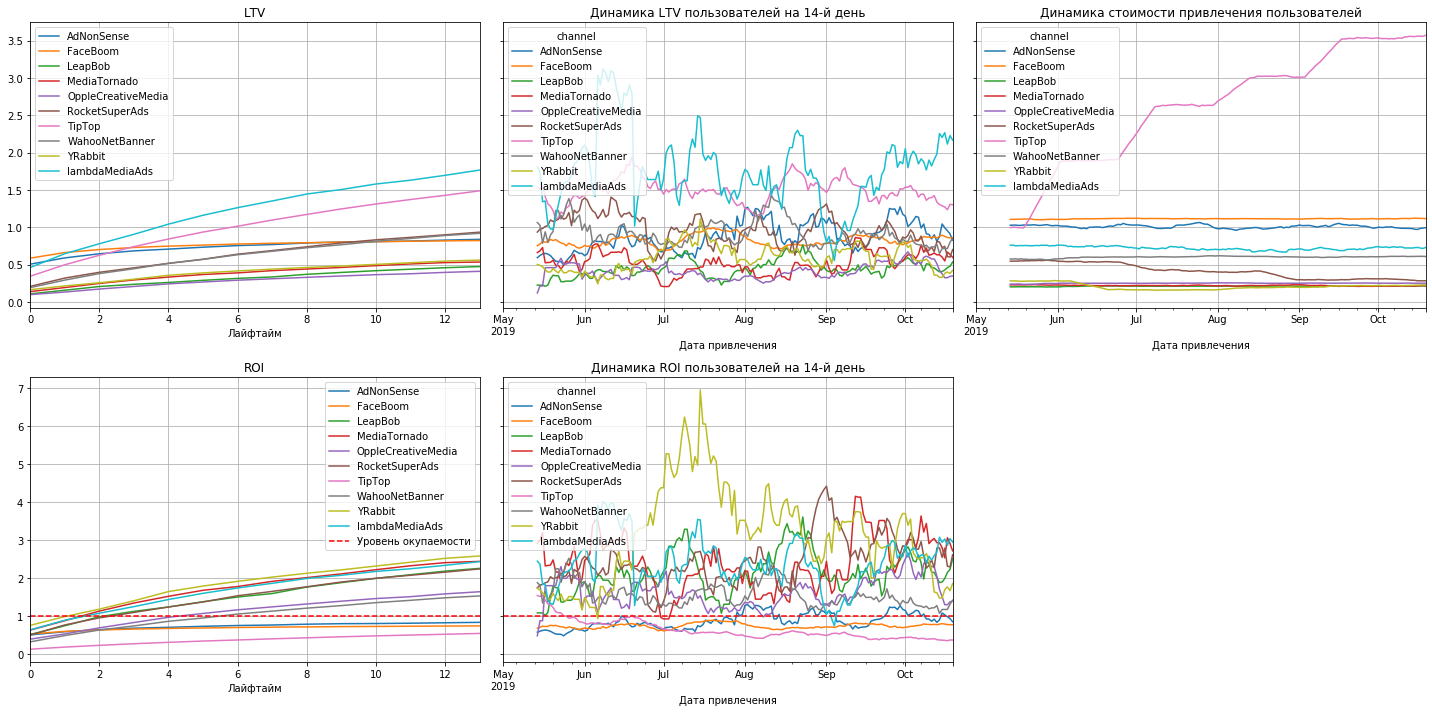

In [46]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видим большой рост стоимости привлечения пользователей из рекламного канала TipTop. Кажется, слишком много средств было потрачено на эту рекламную сеть, но выхлопа от нее получилось не так много, как ожидалось.
Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop.
Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок.

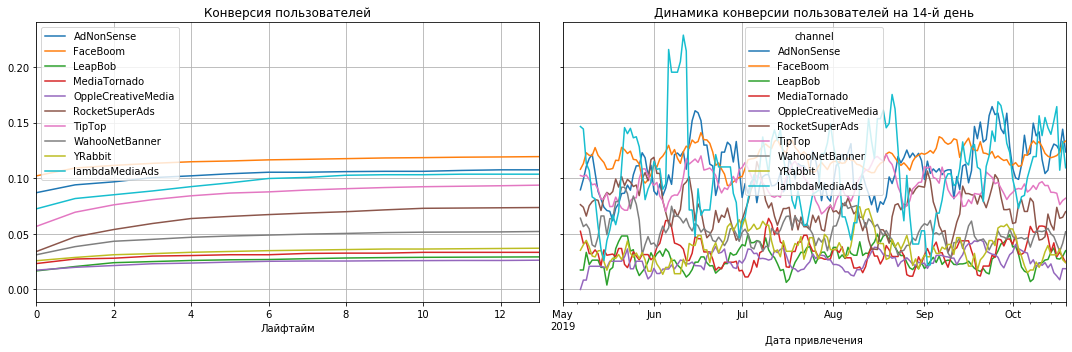

In [47]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Плохая конверсия пользователей из каналов RocketSuperAds, MediaTornado, YRabbit.

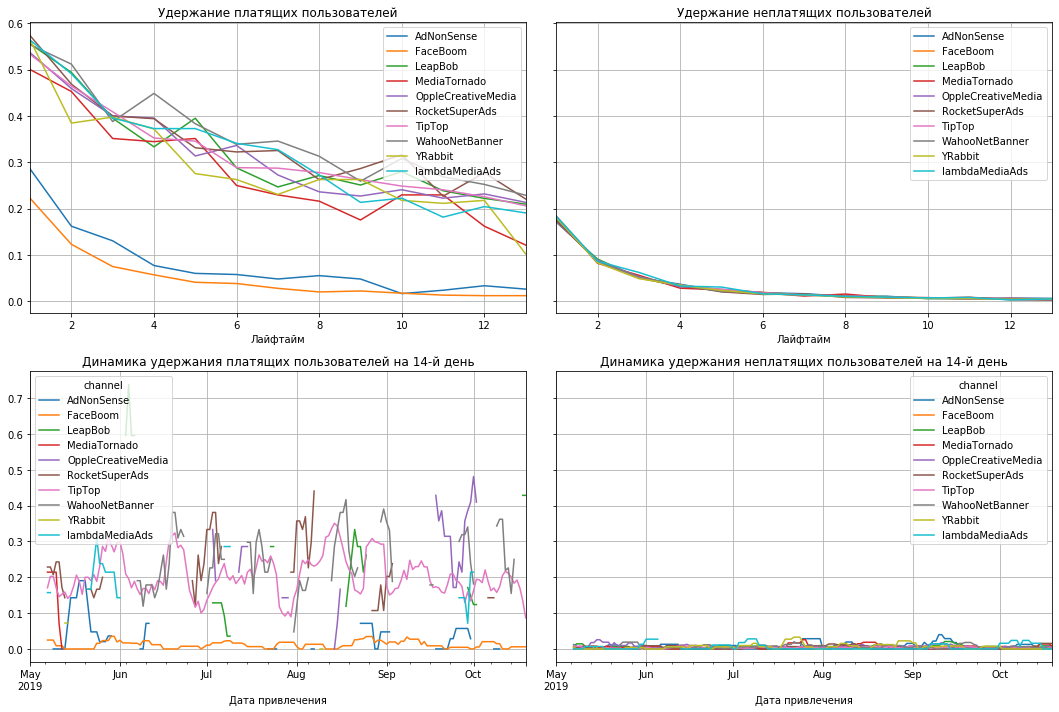

In [48]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

плохо удерживаются пользователи из каналов FaceBoom и AdNonSense.

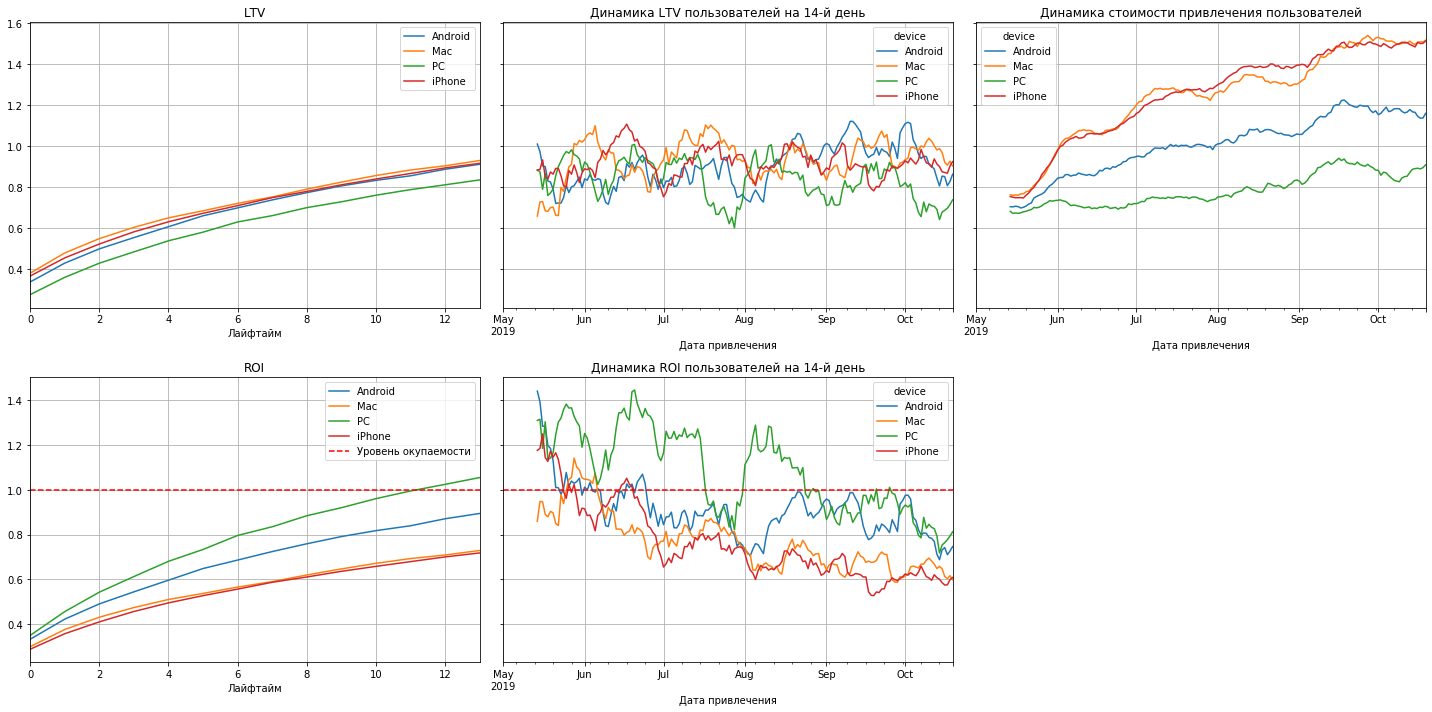

In [49]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

# Вывод по шагу 5
1. Реклама почти окупается к концу 2й недели. ROI — примерно 80%
2. Окупаемость могут снижать владельцы Mac и iPhone, страна - США. 
3. Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop.
4. Проблемы окупаемости могут быть вызваны ненормированным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

<a id="conclusions"> <h1>  Шаг 6. Bыводы </h1> </a>


<b>Причины неэффективности привлечения пользователей</b>

1. Реклама не окупается к концу 2й недели. ROI — около 80%. CAC нестабилен. Рекламный бюджет увеличивается с течением времени. ROI пользователей неумолимо падает. 
2. Пользователи всех устройств окупались до июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. К сентябрю (и какое-то время в августе) ROI пользователей PC на 14 день был на грани окупаемости, ROI всех остальных устройств был уже ниже уровня начиная с июня. В целом стоимость привлечения пользователей всех устройств росла за рассматриваемый период. Направить внимание следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а  окупаемоcть страдает. Судя по графикам, пользователи Mac, Android и iPhone конвертируются неплохо, причём постоянно. Видимо, дело в удержании. 
3. Основная аудитория - это пользователи из США, при этом в США уровень окупаемости рекламы низкий, а стоимость привлечения пользователей из Америки - самая высокая. Лучше всего окупается Англия и Германия. Причем окупаемость пользователей начала падать с конца июня 2019 года. Возможно, сервис стал менеее привлекательным для пользователей. Надо направить внимание на пользователей из США.
4. Заметен большой рост стоимости привлечения пользователей из рекламного канала TipTop, но рекламная кампания не принесла ожидаемых результатов. Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop. Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок. Плохо конвертируются пользователи из каналов RocketSuperAds, MediaTornado, YRabbit. Плохо удерживаются пользователи из каналов FaceBoom и AdNonSense.

<b> Рекомендации для отдела маркетинга для повышения эффективности </b>

1. Направить внимание по окупаемости следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает. Возможно, стоит сделать какое-то маркетинговое предложение именно для владельцев устройств на базе этих ОС, чтобы они приносили продукту бОльшую денежную ценность.
2. Для пользователей из США в целом уровень окупаемости рекламы низкий, а, как мы помним, у нас основная аудитория - это пользователи из США. При этом стоимость привлечения пользователей из Америки - самая высокая. Поэтому стоит также направить силы на балансировку затрат на рекламу по странам.
3. Лучше всего окупается Англия и Германия. Возможно, стоит попробовать закупить больше трафика, целясь на эту аудиторию. Явный аутсайдер по окупаемости - США. Причем окупаемость пользователей начала падать с конца июня 2019 года - стоит также разобраться, что могло послужить причиной.
4. Виден большой рост стоимости привлечения пользователей из рекламного канала TipTop. Кажется, слишком много средств было потрачено на эту рекламную сеть, но рекаламная кампания не оправдала себя. Возможно, стоит уменьшить бюджет, выделяемый на эту сеть и перенаправить его на более эффективный канал.
5. Не окупаются пользватели, привлеченные из каналов LeapBop, FaceBoom, TipTop. Больше всего трафика закупали у TipTop, и к октябрю число трат приближалось к 650 у.е. Число трат на FaceBoom находится в районе 300. Остальные каналы привлечения обходятся довольно дешево. Плохо удерживаются пользователи из каналов FaceBoom и AdNonSense. Можно попробовать переключить внимание на более дешевые, но прибыльные каналы.

